## Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import warnings
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

### Fetching and loading the dataset

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

In [3]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)
print(type(citations))
print(type(papers))
print(papers)

      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns]


### Splitting the data into train and test split

In [4]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

# Obtain paper indices which will be used to gather node states
# from the graph later on when training the model
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

# Obtain ground truth labels corresponding to each paper_id
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

# Print shapes of the graph
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

Edges shape:		 (5429, 2)
Node features shape: (2708, 1433)


### Defining the Graph Attention layers

In [5]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # (1) Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)

        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


### Defining the MultiHeadGraphAttention layers

In [6]:
class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)
    
    def get_config(self):
        config = super(GraphAttentionNetwork, self).get_config()
        config.update({"units": self.units})
        return config


class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            outputs = self([self.node_states, self.edges])
            # Compute loss
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)
        # Apply gradients (update weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute probabilities
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


# Proposed GATNodeClassifier Architectures

#### Defining the hyperparameters

In [8]:
HIDDEN_UNITS = 128
NUM_HEADS = 8
NUM_LAYERS = 16
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.15
LEARNING_RATE = 0.01
MOMENTUM = 0.9

#### Defining the function for Ploting the curves 

In [9]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

### Experiment 3: Proposed GAT Architecture 1

In [10]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

In [11]:
proposed_gat_model = GraphAttentionNetwork(
    node_states, edges, 64, NUM_HEADS, 8, OUTPUT_DIM
)

In [12]:
proposed_gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

history1 = proposed_gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=0.20,
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = proposed_gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

Architectur1 = proposed_gat_model.save("Architecture1.keras")
print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")


Epoch 1/50
9/9 - 92s - 10s/step - acc: 0.1902 - loss: -3.3603e-01 - val_acc: 0.2694 - val_loss: -2.1396e-01
Epoch 2/50
9/9 - 7s - 735ms/step - acc: 0.3241 - loss: -1.5388e-01 - val_acc: 0.3616 - val_loss: -1.5709e-01
Epoch 3/50
9/9 - 6s - 710ms/step - acc: 0.4275 - loss: -1.2349e-01 - val_acc: 0.4059 - val_loss: -1.2550e-01
Epoch 4/50
9/9 - 7s - 771ms/step - acc: 0.5254 - loss: -1.1236e-01 - val_acc: 0.4723 - val_loss: -1.2939e-01
Epoch 5/50
9/9 - 6s - 719ms/step - acc: 0.5799 - loss: -1.1044e-01 - val_acc: 0.4797 - val_loss: -1.2460e-01
Epoch 6/50
9/9 - 7s - 773ms/step - acc: 0.6094 - loss: -1.1274e-01 - val_acc: 0.5498 - val_loss: -1.3016e-01
Epoch 7/50
9/9 - 8s - 846ms/step - acc: 0.6648 - loss: -1.1653e-01 - val_acc: 0.5720 - val_loss: -1.3688e-01
Epoch 8/50
9/9 - 7s - 790ms/step - acc: 0.7128 - loss: -1.2916e-01 - val_acc: 0.6384 - val_loss: -1.4779e-01
Epoch 9/50
9/9 - 8s - 842ms/step - acc: 0.7368 - loss: -1.3359e-01 - val_acc: 0.6531 - val_loss: -1.5251e-01
Epoch 10/50
9/9 - 7s

In [13]:
proposed_gat_model.summary()

Model: "graph_attention_network_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (2708, 512)            │       734,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_3    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_4    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_5    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_6    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_7    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_8    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_9    │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_10   │ ?                      │       263,168 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (2708, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,686,288 (21.69 MB)

 Trainable params: 2,843,143 (10.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,843,145 (10.85 MB)

##### Plotting the curve for experiment 3

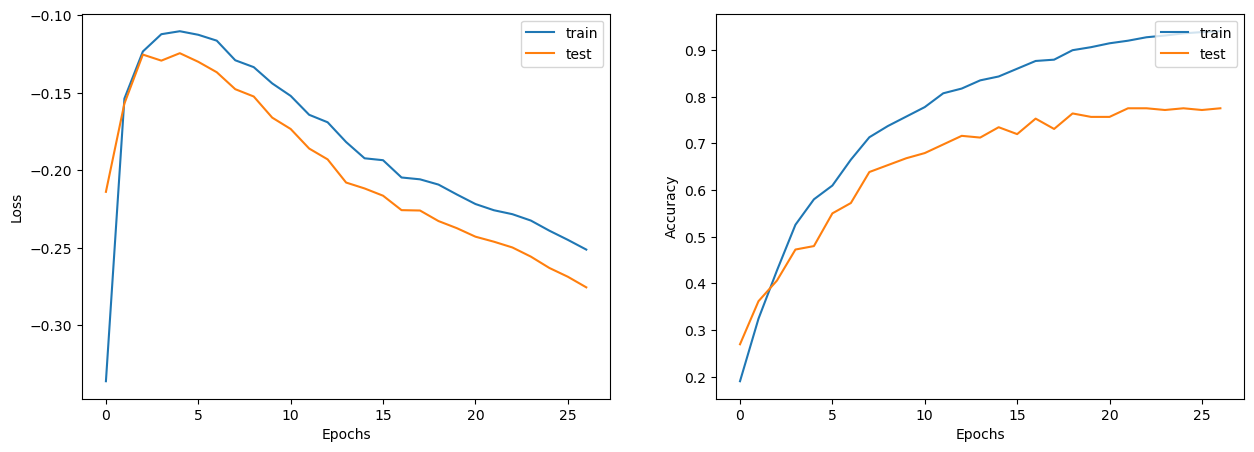

In [14]:
display_learning_curves(history1)

#### Predictions of Experiment 3

In [15]:
test_probs = proposed_gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Instance {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step
Instance 1: Probabilistic_Methods
	Probability of Case_Based               =   6.581%
	Probability of Genetic_Algorithms       =   4.823%
	Probability of Neural_Networks          =  50.310%
	Probability of Probabilistic_Methods    =  20.123%
	Probability of Reinforcement_Learning   =   4.656%
	Probability of Rule_Learning            =   3.536%
	Probability of Theory                   =   9.972%
------------------------------------------------------------
Instance 2: Genetic_Algorithms
	Probability of Case_Based               =   0.535%
	Probability of Genetic_Algorithms       =  99.047%
	Probability of Neural_Networks          =   0.011%
	Probability of Probabilistic_Methods    =   0.005%
	Probability of Reinforcement_Learning   =   0.096%
	Probability of Rule_Learning            =   0.190%
	Probability of Theory                   =   0.115%
------------------------------------------------------------
Instance 3: Theory
	Probability of Case_Bas

#### Confusion Matrix of Experiment 3

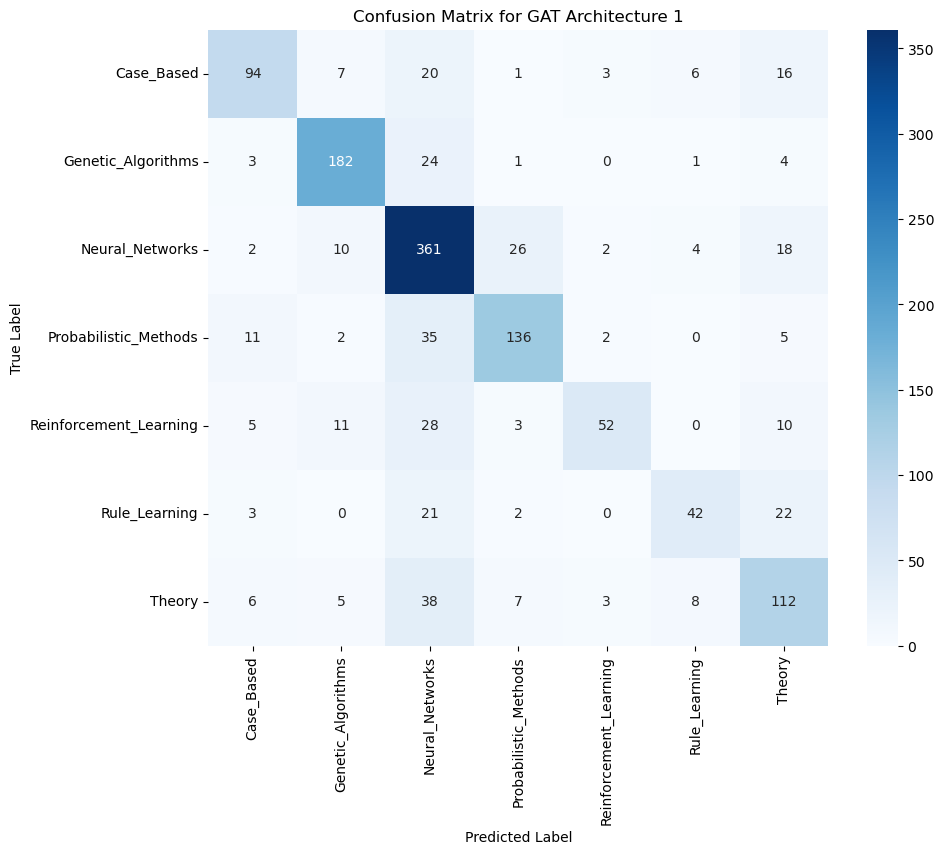

In [16]:
pred_labels = np.argmax(test_probs, axis=1)

# Step 3: Generate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_idx.keys(), yticklabels=class_idx.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GAT Architecture 1')
plt.show()

#### Experiment 4: GATNodeClassifier Architecture 2

In [17]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# Build model
proposed_gat_model2 = GraphAttentionNetwork(
    node_states, edges, 100, NUM_HEADS, 6, OUTPUT_DIM
)

# Compile model
proposed_gat_model2.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])
history2= proposed_gat_model2.fit(
    x=train_indices,
    y=train_labels,
    validation_split=0.20,
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping],
    verbose=2,
)


_, test_accuracy = proposed_gat_model2.evaluate(x=test_indices, y=test_labels, verbose=0)
Architectur2= proposed_gat_model2.save("Architectur2.keras")
print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")


Epoch 1/50
9/9 - 74s - 8s/step - acc: 0.1967 - loss: 0.2152 - val_acc: 0.2620 - val_loss: 0.2023
Epoch 2/50
9/9 - 10s - 1s/step - acc: 0.3361 - loss: 0.1983 - val_acc: 0.3469 - val_loss: 0.1995
Epoch 3/50
9/9 - 9s - 1s/step - acc: 0.4386 - loss: 0.1991 - val_acc: 0.4576 - val_loss: 0.2007
Epoch 4/50
9/9 - 9s - 981ms/step - acc: 0.5466 - loss: 0.2011 - val_acc: 0.5018 - val_loss: 0.2098
Epoch 5/50
9/9 - 9s - 1s/step - acc: 0.6205 - loss: 0.2105 - val_acc: 0.5424 - val_loss: 0.2185
Epoch 6/50
9/9 - 11s - 1s/step - acc: 0.6750 - loss: 0.2240 - val_acc: 0.5683 - val_loss: 0.2334
Epoch 7/50
9/9 - 10s - 1s/step - acc: 0.6981 - loss: 0.2354 - val_acc: 0.6347 - val_loss: 0.2469
Epoch 8/50
9/9 - 10s - 1s/step - acc: 0.7248 - loss: 0.2495 - val_acc: 0.6347 - val_loss: 0.2566
Epoch 9/50
9/9 - 9s - 966ms/step - acc: 0.7553 - loss: 0.2593 - val_acc: 0.6568 - val_loss: 0.2706
Epoch 10/50
9/9 - 8s - 940ms/step - acc: 0.7719 - loss: 0.2722 - val_acc: 0.6900 - val_loss: 0.2731
Epoch 11/50
9/9 - 9s - 98

In [18]:
proposed_gat_model2.summary()

Model: "graph_attention_network_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (2708, 800)            │     1,147,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_11   │ ?                      │       641,600 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_12   │ ?                      │       641,600 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_13   │ ?                      │       641,600 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_14   │ ?                      │       641,600 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_15   │ ?                      │       641,600 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_graph_attention_16   │ ?                      │       641,600 │
│ (MultiHeadGraphAttention)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (2708, 7)              │         5,607 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,004,816 (38.17 MB)

 Trainable params: 5,002,407 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,002,409 (19.08 MB)

#### Plotting the curves for experiment 4

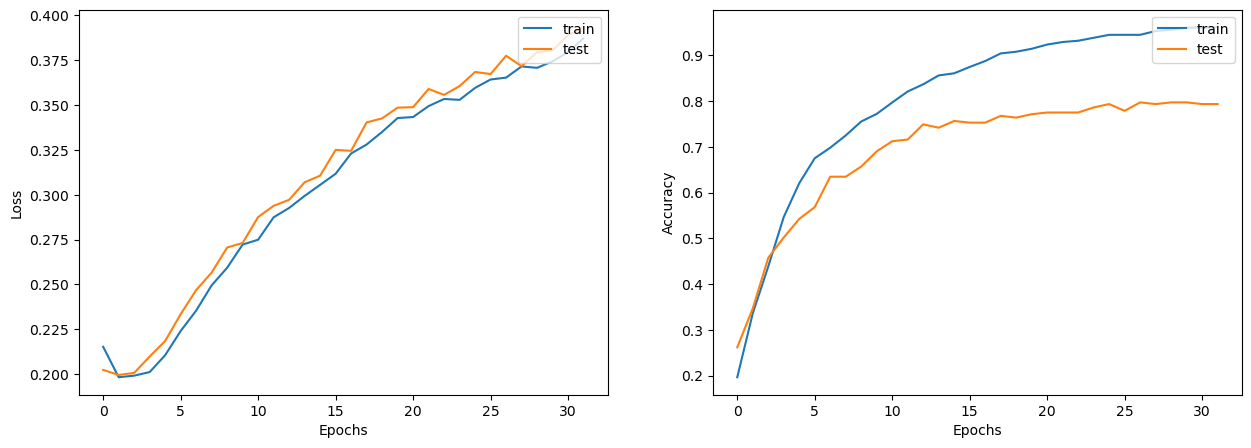

In [19]:
display_learning_curves(history2)

### Predictions of Experiment 4

In [20]:
test_probs2 = proposed_gat_model2.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Instance {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 494ms/step
Instance 1: Probabilistic_Methods
	Probability of Case_Based               =   6.581%
	Probability of Genetic_Algorithms       =   4.823%
	Probability of Neural_Networks          =  50.310%
	Probability of Probabilistic_Methods    =  20.123%
	Probability of Reinforcement_Learning   =   4.656%
	Probability of Rule_Learning            =   3.536%
	Probability of Theory                   =   9.972%
------------------------------------------------------------
Instance 2: Genetic_Algorithms
	Probability of Case_Based               =   0.535%
	Probability of Genetic_Algorithms       =  99.047%
	Probability of Neural_Networks          =   0.011%
	Probability of Probabilistic_Methods    =   0.005%
	Probability of Reinforcement_Learning   =   0.096%
	Probability of Rule_Learning            =   0.190%
	Probability of Theory                   =   0.115%
------------------------------------------------------------
Instance 3: Theory
	Probability of Case_Bas

#### Confusion Matrix for Experiment 4

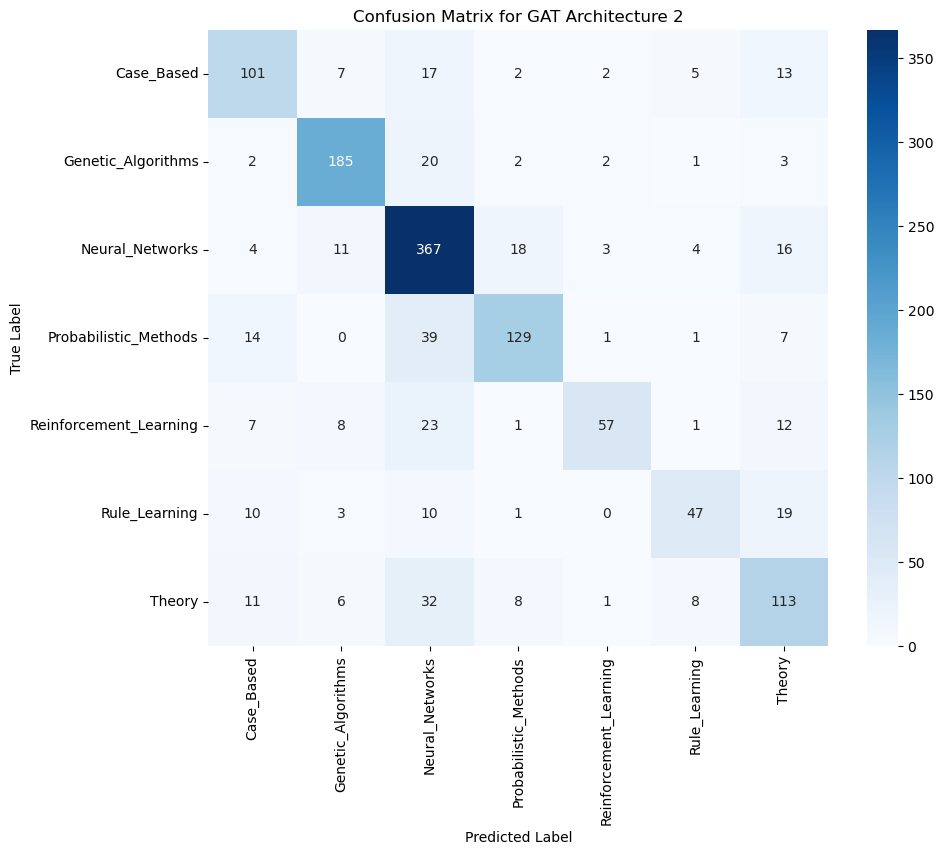

In [21]:
pred_labels2 = np.argmax(test_probs2, axis=1)

# Step 3: Generate confusion matrix
cm2 = confusion_matrix(test_labels, pred_labels2)

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_idx.keys(), yticklabels=class_idx.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GAT Architecture 2')
plt.show()
